In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from pathlib import Path
from glob import glob
from tqdm.auto import tqdm
import numpy as np
from scipy.spatial import KDTree
from matplotlib import pyplot as plt
import matplotlib
import tiledb
from tqdm.auto import tqdm
import geopandas as gpd

In [3]:
from pyspatialkit.storage.geostorage import GeoStorage
from pyspatialkit.dataobjects.geoshape import GeoShape
from pyspatialkit.dataobjects.georaster import GeoRaster
from pyspatialkit.dataobjects.geopointcloud import GeoPointCloud
from pyspatialkit.spacedescriptors.georect import GeoRect
from pyspatialkit.crs.geocrs import GeoCrs
from pyspatialkit.spacedescriptors.geobox2d import GeoBox2d
from pyspatialkit.visualization.cesium.backend.server import start_server
from pyspatialkit.layerprocessing.decorators import layerprocessor
from pyspatialkit.storage.raster.georasterlayer import GeoRasterLayer
from pyspatialkit.storage.pointcloud.geopointcloudlayer import GeoPointCloudLayer
from pyspatialkit.tiling.geoboxtiler2d import GeoBoxTiler2d

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
DATA_PATH = Path('/hpi/fs00/home/tobias.pietz/pyspatialkit/data/')
TMP_DATA_PATH = Path('/tmp/pyspatialkit/data/')
GEOSTORAGE_PATH = TMP_DATA_PATH / 'geostore/'
CRS = GeoCrs.from_epsg(25832)
AOI = GeoShape.from_shapefile(DATA_PATH / 'aoi.shp').to_crs(CRS)
AOI_BOUNDS = AOI.bounds

In [14]:
storage = GeoStorage(GEOSTORAGE_PATH)

extent:[ 71271.3483359   43257.17673566 120000.        ]
extent:[ 71271.3483359   43257.17673566 120000.        ]


In [8]:
rgbi_layer = storage.get_layer('rgbi')
dom_layer = storage.get_layer('dom')
dgm_layer = storage.get_layer('dgm')
res_layer = storage.get_layer('result')

In [24]:
import os
list(Path(os.path.realpath(DATA_PATH)).parents)

[PosixPath('/hpi/fs00/home/tobias.pietz/pyspatialkit'),
 PosixPath('/hpi/fs00/home/tobias.pietz'),
 PosixPath('/hpi/fs00/home'),
 PosixPath('/hpi/fs00'),
 PosixPath('/hpi'),
 PosixPath('/')]

In [7]:
rgbi_layer.commit_pyramid_update_transaction()

start consolidating
consoldating tiledb array at /tmp/pyspatialkit/data/geostore/rgbi/backend/layer_0 ...
consoldating tiledb array at /tmp/pyspatialkit/data/geostore/rgbi/backend/layer_1 ...
consoldating tiledb array at /tmp/pyspatialkit/data/geostore/rgbi/backend/layer_2 ...
consoldating tiledb array at /tmp/pyspatialkit/data/geostore/rgbi/backend/layer_3 ...
consoldating tiledb array at /tmp/pyspatialkit/data/geostore/rgbi/backend/layer_4 ...
consoldating tiledb array at /tmp/pyspatialkit/data/geostore/rgbi/backend/layer_5 ...
consoldating tiledb array at /tmp/pyspatialkit/data/geostore/rgbi/backend/layer_6 ...
consoldating tiledb array at /tmp/pyspatialkit/data/geostore/rgbi/backend/layer_7 ...
consoldating tiledb array at /tmp/pyspatialkit/data/geostore/rgbi/backend/layer_8 ...
consoldating tiledb array at /tmp/pyspatialkit/data/geostore/rgbi/backend/layer_9 ...
consoldating tiledb array at /tmp/pyspatialkit/data/geostore/rgbi/backend/layer_10 ...
consoldating tiledb array at /tmp

In [14]:
res_layer = storage.add_raster_layer('result', num_bands = 1, dtype=np.uint8, crs=CRS, bounds=AOI_BOUNDS,
                                      build_pyramid=False)

In [7]:
#test_bounds = (722830.9, 5747402.9, 723030.6, 5747608.7)
test_bounds = (718908, 5745014, 719908, 5746014)
test_box = GeoBox2d.from_bounds(test_bounds, crs=CRS)
test_rect = test_box.to_georect()

In [8]:
img = res_layer.get_data(test_rect)

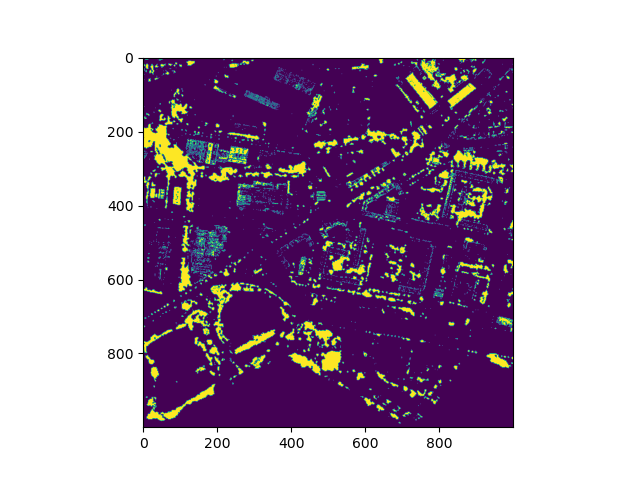

In [9]:
img.plot()

In [22]:
@layerprocessor
def tree_detection(box: GeoBox2d, rgbi_layer: GeoRasterLayer, dom_layer: GeoPointCloudLayer, dgm_layer: GeoPointCloudLayer, res_layer: GeoRasterLayer):
    georect = box.to_georect()
    rgb_raster = rgbi_layer.get_data(georect)
    dom_pc = dom_layer.get_data(GeoBox2d.from_georect(georect))
    dgm_pc = dgm_layer.get_data(GeoBox2d.from_georect(georect))
    dgm_raster = GeoRaster(rgb_raster.georect, np.zeros((*rgb_raster.shape[:2], 1)))
    dgm_raster = dgm_pc.project_to_georaster(georaster=dgm_raster, value_field='height', interpolate_holes=True)
    dom_raster = GeoRaster(rgb_raster.georect, np.zeros((*rgb_raster.shape[:2], 1)))
    dom_raster = dom_pc.project_to_georaster(georaster=dom_raster, value_field='height', interpolate_holes=True)
    height_above_ground = dom_raster.data - dgm_raster.data
    ndvi = (rgb_raster.data[:,:,3] - rgb_raster.data[:,:,0]) / (rgb_raster.data[:,:,3] + rgb_raster.data[:,:,0])
    mask = (ndvi >= NDVI_THRESH) & (height_above_ground[:,:,0] >= MIN_TREE_HEIGHT)
    result = GeoRaster(georect, mask.astype(np.uint8) * 255)
    res_layer.write_data(result)

In [20]:
test_aoi = GeoBox2d.from_bounds((718908, 5745014, 725759, 5748917), crs=CRS)

In [21]:
tiler = GeoBoxTiler2d(aoi=test_aoi, raster_size=(1000,1000), reference_crs=CRS)

In [25]:
tree_detection(tiler=tiler, num_workers=1)(rgbi_layer, dom_layer, dgm_layer, res_layer)

PicklingError: Could not pickle the task to send it to the workers.